# Comparing performance of different crystal structure representations

In this notebook, we'll compare the performance of three different crystal structure representations, which are Coulomb Matrix (CM), Partial Radial Distribution Function (PRDF) and Voronoi tessellation features shown in [Ward et al's paper](https://journals.aps.org/prb/abstract/10.1103/PhysRevB.96.024104). 

In [1]:
import numpy as np
import pandas as pd
import os
import pickle
import time
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm

from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

Load data

In [ ]:
%%time
X_ward = pickle.load(open('./X_ward.pkl', 'rb'))
X_cm = pickle.load(open('./X_cm.pkl', 'rb'))
X_prdf = pickle.load(open('./X_prdf.pkl', 'rb'))

y = pickle.load(open('./y.pkl', 'rb'))

In [ ]:
print ("Shape of X_ward:", X_ward.shape)
print ("Shape of X_cm:", X_cm.shape)
print ("Shape of X_prdf:", X_prdf.shape)
print ("Shape of y:", y.shape)

## Training RandomForestRegressor model

A set of randomly selected 30,000 entries is used to train the model. Performance of the model is then evaluted on a distinct set of around 1000 entries. Each cross-validation test is repeated 20 times. 

In [ ]:
ft = ['ward', 'cm', 'prdf']

In [ ]:
X = {"ward": X_ward, "cm": X_cm, "prdf": X_prdf}

Training RandomForestRegressor with respective training set and compute the stats

In [ ]:
stats, pred, calc = dict.fromkeys(ft), dict.fromkeys(ft), dict.fromkeys(ft)
for ft in stats:
    stats[ft] = dict.fromkeys(['mae', 'rmse', 'r2', 'time_used'], 0.0)

In [ ]:
for ft, x in X.items():
    print ("Featurization:", ft)
    print (" -- Is there any NaN values? :", np.any(np.isnan(x)))
    print (" -- Are all values finite? :", np.all(np.isfinite(x)))
    for train_idx, test_idx in tqdm(ShuffleSplit(train_size=30000, test_size=1000, n_splits=20).split(x)):
        # split dataset
        x_train, x_test = X[ft][train_idx], X[ft][test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
    
        # compute time used to train model
        start = time.perf_counter()
        
        # Use pipeline
        model = Pipeline([
                    ('imputer', Imputer(missing_values='NaN', strategy='mean', axis=1)), # For the failed structures
                    ('model', RandomForestRegressor(n_estimators=100, n_jobs=-1))
                    ])
        # train model
        model.fit(x_train, y_train)
        
        # run model
        y_pred = model.predict(x_test)
        
        finish = time.perf_counter()
        
        # compute stats
        stats[ft]['mae'] += mean_absolute_error(y_pred, y_test) / 20
        stats[ft]['rmse'] += np.sqrt(mean_squared_error(y_pred, y_test)) / 20
        stats[ft]['r2'] += r2_score(y_pred, y_test) / 20
        stats[ft]['time_used'] += (finish - start) / 20
        
    # save predicted formation enthalpy at last iteration
    pred[ft], calc[ft] = y_pred, y_test
    print ()

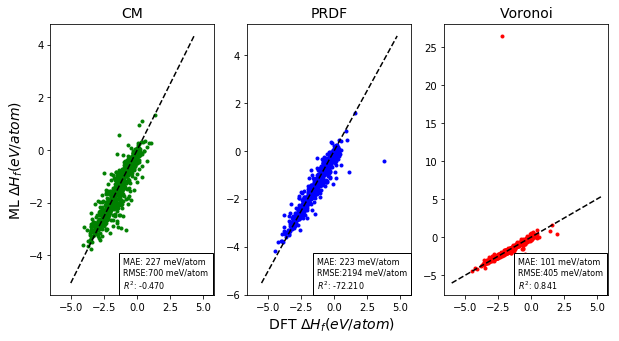

In [3]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True)

ax1.set_title("CM", fontsize=14)
ax2.set_title("PRDF", fontsize=14)
ax3.set_title("Voronoi", fontsize=14)

ax1.set_ylabel("ML $\Delta H_f (eV/atom)$", fontsize=14)
ax2.set_xlabel(" DFT $\Delta H_f (eV/atom)$", fontsize=14)

ax1.scatter(calc['cm'], pred['cm'], color='g', marker='.')
ax2.scatter(calc['prdf'], pred['prdf'], color='b', marker='.')
ax3.scatter(calc['ward'], pred['ward'], color='r', marker='.')

ax1.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax2.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')
ax3.plot(ax1.get_xlim(), ax1.get_xlim(), 'k--')

ax1.text(0.445, 0.026, 'MAE: {:.0f} meV/atom\nRMSE:{:.0f} meV/atom\n$R^2$: {:.3f}'.format(stats['cm']['mae']*1e3, stats['cm']['rmse']*1e3, stats['cm']['r2']),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax2.text(1.625, 0.026, 'MAE: {:.0f} meV/atom\nRMSE:{:.0f} meV/atom\n$R^2$: {:.3f}'.format(stats['prdf']['mae']*1e3, stats['prdf']['rmse']*1e3, stats['prdf']['r2']),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})
ax3.text(2.85, 0.026, 'MAE: {:.0f} meV/atom\nRMSE:{:.0f} meV/atom\n$R^2$: {:.3f}'.format(stats['ward']['mae']*1e3, stats['ward']['rmse']*1e3, stats['ward']['r2']),
         transform=ax1.transAxes, fontsize=8,
         bbox={'facecolor': 'w', 'edgecolor': 'k'})

fig.subplots_adjust(wspace=0.2)
fig.set_size_inches((10, 5))